Classfies Related Medical Field, by patient's response

Text Pre-processing of patient's response to change to Vector, then had Bi-LSTM to compute the sequence then applied Attention Mechanism to it, and then added a Classification Linear Layer for Identifying Related Medical Field

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow_text
import tensorflow_text as text
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import *
import tensorflow_hub as hub
from keras.models import Model
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('TRAIN.csv')
test = pd.read_csv('TEST.csv')
train = train.astype(str)
test = test.astype(str)

train = train.drop(['index', 'Unnamed: 0'], axis=1)
test = test.drop(['index', 'Unnamed: 0'], axis=1)

In [ ]:
X_train_description = train['Description'].to_numpy()
x_description = np.asarray(X_train_description).astype(str)

X_train_patient_dialogue = train['Patient dialogue'].to_numpy()
x_train_patient_dialogue = np.asarray(X_train_patient_dialogue).astype(str)

X_train_doctor_dialogue = train['Doctor dialogue'].to_numpy()
X_train_doctor_dialogue = np.asarray(X_train_doctor_dialogue).astype(str)


X_test_description = test['Description'].to_numpy()
x_test_description = np.asarray(X_test_description).astype(str)

X_test_patient_dialogue = test['Patient dialogue'].to_numpy()
x_test_patient_dialogue = np.asarray(X_test_patient_dialogue).astype(str)

X_test_doctor_dialogue = test['Doctor dialogue'].to_numpy()
X_test_doctor_dialogue = np.asarray(X_test_doctor_dialogue).astype(str)

In [ ]:
lst = list(train['Tag 1'].unique())

In [ ]:
y_train = pd.get_dummies(train['Tag 1'])
y_test = pd.get_dummies(test['Tag 1'])

y_train_ = np.asarray(y_train.values).astype('float32')
y_test_ = np.asarray(y_test.values).astype('float32')

In [ ]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
text_inputs = [tf.keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]
seq_length = 512
bert_pack_inputs = hub.KerasLayer(preprocessor.bert_pack_inputs, arguments=dict(seq_length=seq_length))
encoder_inputs = bert_pack_inputs(tokenized_inputs)
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
outputs = encoder(encoder_inputs)
pooled_output = outputs["sequence_output"]
embedding_model = tf.keras.Model(text_inputs, pooled_output)

In [ ]:
from keras.layers import Layer
import keras.backend as K

# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
text_input_description = Input(shape=(),dtype=tf.string,name='Description')
text_input_patient_dialogue = Input(shape=(),dtype=tf.string, name='Patient dialogue')
text_input_doctor_dialogue = Input(shape=(), dtype=tf.string, name='Doctor dialogue')

encode_output_description = embedding_model(text_input_description)
encode_output_patient_dialogue = embedding_model(text_input_patient_dialogue)
encoded_output_doctor_dialogue = embedding_model(text_input_doctor_dialogue)

bilstm_description = Bidirectional(CuDNNLSTM(units=256,return_sequences=True))(encode_output_description)
bilstm_patient_dialogue = Bidirectional(CuDNNLSTM(units=128,return_sequences=True))(encode_output_patient_dialogue)
bilstm_doctor_dialogue = Bidirectional(CuDNNLSTM(units=128, return_sequences=True))(encoded_output_doctor_dialogue)

concat = Concatenate()([bilstm_doctor_dialogue])

att = attention()(bilstm_doctor_dialogue)

output = Dense(20, activation='softmax')(att)
model = Model(inputs=text_input_doctor_dialogue,outputs=output)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Doctor dialogue (InputLayer  [(None,)]                0         
 )                                                               
                                                                 
 model (Functional)          (None, 512, 768)          109482241 
                                                                 
 bidirectional_2 (Bidirectio  (None, 512, 256)         919552    
 nal)                                                            
                                                                 
 attention (attention)       (None, 256)               768       
                                                                 
 dense (Dense)               (None, 20)                5140      
                                                                 
Total params: 110,407,701
Trainable params: 925,460
Non-tra

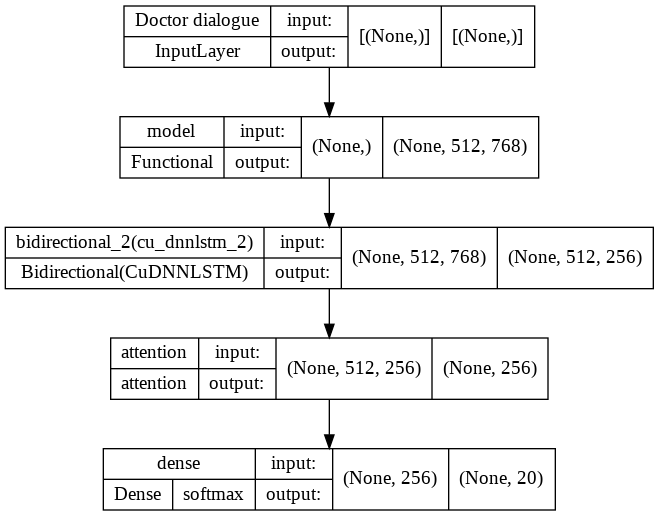

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

# Training...

In [ ]:
model.load_weights('/content/drive/MyDrive/doctor.h5')

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/doctor.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=5, 
                                               verbose=1)

hist = model.fit(X_train_doctor_dialogue, y_train_, 
                epochs=100, 
                batch_size=4, 
                verbose=1,
                callbacks=[early_stopping,model_checkpoint_callback])

Epoch 1/100
1100/1100 [==============================] - 238s 199ms/step - loss: 0.0616 - accuracy: 0.9843
Epoch 2/100
1100/1100 [==============================] - 224s 204ms/step - loss: 0.0461 - accuracy: 0.9884
Epoch 3/100
1100/1100 [==============================] - 220s 200ms/step - loss: 0.0782 - accuracy: 0.9777
Epoch 4/100
1100/1100 [==============================] - 219s 199ms/step - loss: 0.0606 - accuracy: 0.9834
Epoch 5/100
1100/1100 [==============================] - 219s 199ms/step - loss: 0.0572 - accuracy: 0.9848
Epoch 6/100
1100/1100 [==============================] - 222s 202ms/step - loss: 0.0236 - accuracy: 0.9945
Epoch 7/100
1100/1100 [==============================] - 219s 199ms/step - loss: 0.0238 - accuracy: 0.9939
Epoch 8/100
1100/1100 [==============================] - 219s 199ms/step - loss: 0.0825 - accuracy: 0.9752
Epoch 9/100
1100/1100 [==============================] - 219s 199ms/step - loss: 0.0245 - accuracy: 0.9941
Epoch 10/100
1100/1100 [=============

# Loading pretrained model

In [ ]:
model.load_weights('/content/drive/MyDrive/doctor.h5')

In [ ]:
model.evaluate(X_test_doctor_dialogue, y_test_, batch_size=1)

1101/1101 [==============================] - 60s 53ms/step - loss: 2.7472 - accuracy: 0.5631


[2.7472455501556396, 0.563124418258667]

In [ ]:
pred = model.predict(X_test_doctor_dialogue)

In [ ]:
lst = sorted(list(train['Tag 1'].unique()))

In [ ]:
text = []
pred_values=[]
p_dialogue=[]
d_dialogue=[]
y_true=[]
for i in range(len(X_test_description)):
  text.append(X_test_description[i])
  pred_values.append(lst[np.argmax(pred[i])])
  d_dialogue.append(X_test_doctor_dialogue[i])
  y_true.append(lst[np.argmax(y_test_[i])])

output = pd.DataFrame(list(zip(d_dialogue, y_true, pred_values)),
               columns =['Doctor dialogue', 'True value', 'Predicted value'])

In [ ]:
output

,Doctor dialogue,True value,Predicted value
0,"Hi Dear,Understanding your concern.As per your...",Dermatology,Dermatology
1,"Hi, I had gone through your question and under...",Pulmonology,Paediatrics
2,"Hallow Dear Martha,Brown bleeding during any s...",obstetrics and gynecology (OB-GYN),obstetrics and gynecology (OB-GYN)
3,"Hi, Welcome to the forum. It is nice to know y...",Hepatology,Hepatology
4,"Hi,Thanks for your query.The initial managem...",Orthopaedics,Orthopaedics
...,...,...,...
1096,doctor: Thanks for your question on Health Car...,Pulmonology,Pulmonology
1097,hi iam DR.NALLAMMAIWELCOME TO HCMthe symptoms...,Gastroenterology,Gastroenterology
1098,"Hi, thanks for posting a question on our site....",Cardiology,Cardiology
1099,"Hello, All your blood investigation are in no...",Pharmacology,Haematology


In [ ]:
output.to_csv('output_doctor_dialogue.csv')

In [ ]:
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test_, axis=1)

from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.5001786558796273
F1 score(micro) 0.5631244323342416


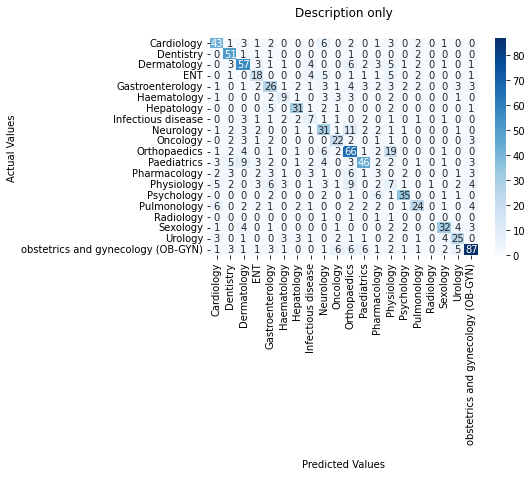

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(confusion, annot=True, cmap='Blues')
ax.xaxis.set_ticklabels(lst)
ax.yaxis.set_ticklabels(lst)
ax.set_title('Description only\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
output.to_csv('/content/doctor_output(BPM).csv')